# Fraud detection with imbalanced dataset 

This notebook will test fraud detection with imbalanced dataSet using diffrent classifcation methods. 

Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

My solution is to use diffrent classfication methods +  tactics that can be use to provide good results with imbalanced datasets  :


a. UnderSampling
b. OverSampling 
c. Balanced weight 
d.XGboost



![](https://www.google.com/search?q=autoencoder+for+anomaly+detection+keras&rlz=1C1GCEA_enIL866IL866&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiQztaRleLoAhWrBWMBHRKfCe8Q_AUoAnoECAwQBA&biw=1920&bih=937#imgrc=t8UiO_9h1cy-UM)

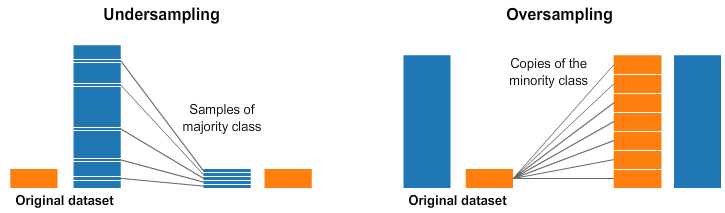


# Imports

In [1]:
import numpy as np
import pandas as pd 
import zipfile
from keras.preprocessing.image import ImageDataGenerator, load_img
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from subprocess import check_output
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import pickle
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support
from sklearn.model_selection import train_test_split , cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#Handle imbalance dataset
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, accuracy_score, f1_score
%matplotlib inline

# Warnings
import warnings as ws
ws.filterwarnings('ignore')

print(check_output(["ls", "../input/"]).decode("utf8"))


Using TensorFlow backend.


creditcard.csv



# Read Data from credit CSV

In [2]:
try:
    data = pd.read_csv("../input/creditcard.csv")
except Exception as e:
    data = pd.read_csv("creditcard.csv")
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


# we can see the V1-V28 (28 features extracted from PCA on original data )

Let's see if we have missing data

In [3]:
data.isnull().values.any()


False

# Check how much examples we have per Class

In [4]:
# Print Class0 & Class1 Frequency & Ratio
def get_class0_class1_ratio(y_train):
    
    print('Train - Class0 & Class1 Frequency & Ratio : \n\n')
    
    print('class 0 - Normal : Count fom total Train :{} , Ratio of samples from total train size  : {} %'.format(y_train.value_counts()[0],np.round(y_train.value_counts()[0]/len(y_train),4)))
    print('class 1 - Fraud  : Count fom total Train :{} , Ratio of samples from total train size  : {} %'.format(y_train.value_counts()[1],np.round(y_train.value_counts()[1]/len(y_train),4)))

In [5]:
def plot_confusion_matrix(y_test,y_pred):
    
    cnf_matrix = confusion_matrix(y_test, y_pred)    
    
    plt.figure(figsize = (10,10))
    sns.heatmap(cnf_matrix, annot = True, fmt = 'g') 
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
def plot_precision_recall_curve(y_test,y_score):


    plt.figure(figsize=(10,10))

    precision, recall, th=precision_recall_curve(y_test,y_score)

    plt.plot(recall, precision)
    auprc = auc(recall, precision)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.title("Precision Vs Recall curve")
    plt.legend(['AUPRC = %0.4f'% auprc])

In [7]:
 def plot_summary_results(y_test,y_pred):


    print('Classification report : \n\n')

    print(classification_report(y_test, y_pred))

In [8]:
def plot_summary(y_test,y_score):
  #  y_test=y_test_os
  #  y_score=y_score_os
    

    F1_score=[]

    plt.figure(figsize=(10,10))

    precision, recall, th=precision_recall_curve(y_test,y_score)

    F1_score = 2 * (precision * recall) / (precision + recall)
    optimal_th_fscore = th[np.argmax(F1_score)]
    optimal_th_recall = th[np.argmax(recall)]
    if (np.argmax(precision)==len(th)) :
        
      optimal_th_precision = th[np.argmax(precision)-1]
    else :
      optimal_th_precision = th[np.argmax(precision)]
        
    
    print('Maximal F1 Score : ', str(max(F1_score)))
    print('Maximal  Recall: ', str(max(recall)))
    print('Maximal Precision : ', str(max(precision)))

    print('Optimal Threshold Fscore : ' + str(optimal_th_fscore))
    print('Optimal Threshold Recall: ' + str(optimal_th_recall))
    print('Optimal Threshold Precision: ' + str(optimal_th_precision))
    
    idx_optimal_fscore_recall = np.argwhere(np.diff(np.sign(F1_score - recall))).flatten()
    fidx_optimal_fscore_recall=idx_optimal_fscore_recall[0]

    print('Optimal Threshold Recall & F1 score intersection : {} , F1 score value = {} Recall Value = {} '.format(th[fidx_optimal_fscore_recall],F1_score[fidx_optimal_fscore_recall],recall[fidx_optimal_fscore_recall]))

    
    plt.plot(th, precision[1:], 'r', label='Threshold-Precision curve')
    plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
    plt.plot(th, F1_score[1:], 'g', label='Threshold-Recall curve')

    plt.title('Precision & Recall & F1 score Vs Threshold')
    plt.xlabel('threshold')
    #plt.xlim(xmin=0)

    plt.ylabel('Precision & Recall & F1')
    plt.legend(['Precision','Recall', 'F1 score'])

    plt.show()


count for each class : 

0    284315
1       492
Name: Class, dtype: int64

percent of fraud : 0.1727485630620034%


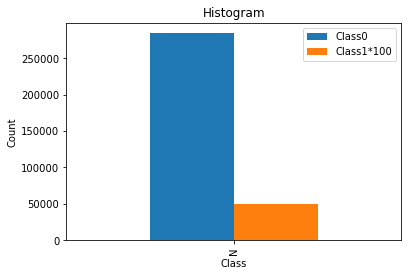

In [9]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()

df = pd.DataFrame({'Class0':count_classes[0], 'Class1*100':count_classes[1]*100}, index=['N']) #
df.plot(kind='bar')
plt.title("Histogram")
plt.xlabel("Class")
plt.ylabel("Count")

print("count for each class : \n\n" + str(count_classes) + "\n")
print ('percent of fraud : ' + str(100*count_classes[1]/(sum(count_classes))) + "%")

# Since Amount feature is unbalance and can get high values comapring to other V1-V28 features I'll center the data using fit transform

I'll drop Time feature since it didn't improve loss & acc

In [10]:

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
#data = data.drop(['Time'],axis=1) #,'Amount'
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


# Train test split

In [11]:
bad_data = data[data['Class'] == 1]
bad_data2=bad_data['Class']
bad_data=bad_data.drop(['Class'], axis=1)
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = X_train[X_train['Class']==0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_test2=np.concatenate([bad_data, X_test])
y_test2 = np.concatenate([bad_data2, y_test])

X_all=data
X_all=X_all.drop(['Class'], axis=1)
X_all['Amount'] = StandardScaler().fit_transform(X_all['Amount'].values.reshape(-1, 1))
#X_all['Time'] = StandardScaler().fit_transform(X_all['Time'].values.reshape(-1, 1))
X_all = X_all.drop(['Time'],axis=1) #,'Amount'


Y_all=data['Class']

# unbalanced data set with logistic regression

Train - Class0 & Class1 Frequency & Ratio : 


class 0 - Normal : Count fom total Train :284315 , Ratio of samples from total train size  : 0.9983 %
class 1 - Fraud  : Count fom total Train :492 , Ratio of samples from total train size  : 0.0017 %


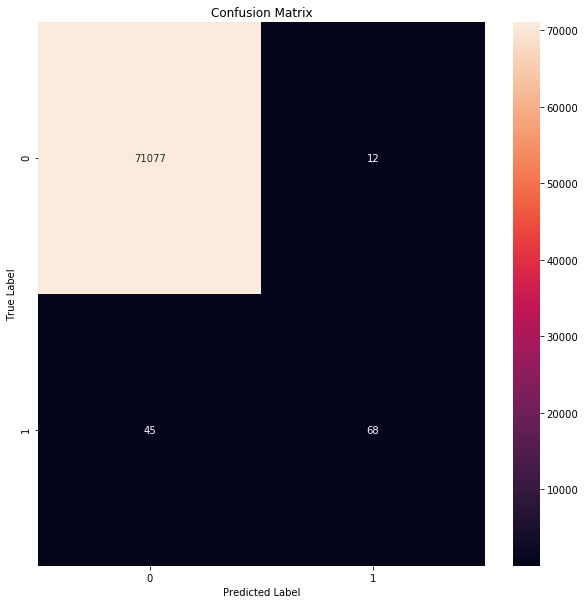

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_all, Y_all, test_size = 0.25, random_state = 42)

base_model =  LogisticRegression()
base_model.fit(x_train, y_train)

y_pred = base_model.predict(x_test)
y_score = base_model.decision_function(x_test)

get_class0_class1_ratio(Y_all)
plot_confusion_matrix(y_test, y_pred)

Classification report : 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.85      0.60      0.70       113

    accuracy                           1.00     71202
   macro avg       0.92      0.80      0.85     71202
weighted avg       1.00      1.00      1.00     71202



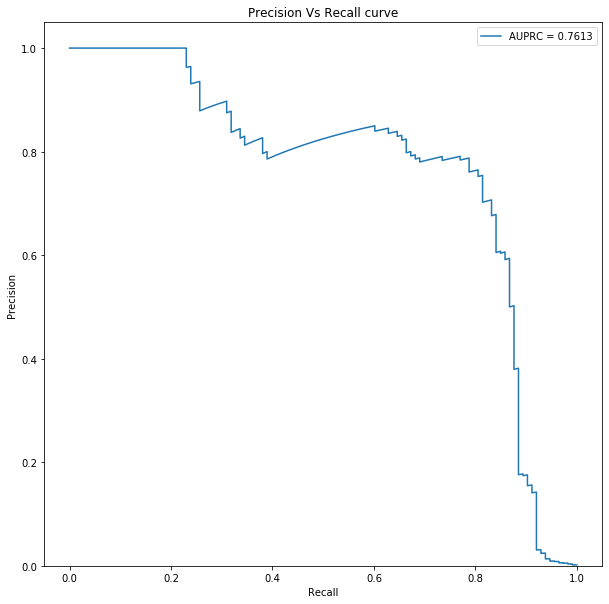

In [13]:
plot_precision_recall_curve(y_test,y_score)
plot_summary_results(y_test,y_pred)
#plot_summary(y_test,y_score)

Here Recall ~0.6 & F1 Score of oversampling class 1(Fraud) is ~0.85


# Random Undersampling

Randomly remove samples in the majority class(In our case Class normal transactions - Class 0 )
We'll reduce majority class(Class=0) to minoriy class(Class=1) level
Need to assure we have enough training samples ( ~X10 from model parmeters) before fitting the model.

This technique could perform well in training dataset but might dissatisfy for new datasets.

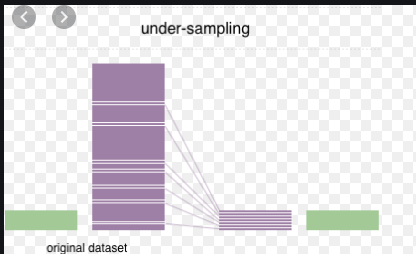

Train - Class0 & Class1 Frequency & Ratio : 


class 0 - Normal : Count fom total Train :492 , Ratio of samples from total train size  : 0.5 %
class 1 - Fraud  : Count fom total Train :492 , Ratio of samples from total train size  : 0.5 %


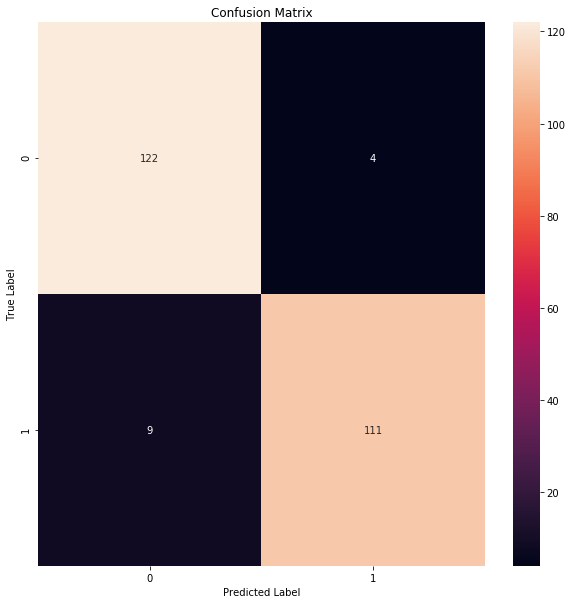

In [14]:
undersampling = NearMiss()
X_US, Y_US = undersampling.fit_sample(X_all,Y_all)
 
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(X_US, Y_US, test_size = 0.25, random_state = 42)

undersampling_model =  LogisticRegression()
undersampling_model.fit(x_train_us, y_train_us)

y_pred_us = undersampling_model.predict(x_test_us)
y_score_us = undersampling_model.decision_function(x_test_us)

get_class0_class1_ratio(Y_US)
plot_confusion_matrix(y_test_us, y_pred_us)


Classification report : 


              precision    recall  f1-score   support

           0       0.93      0.97      0.95       126
           1       0.97      0.93      0.94       120

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246



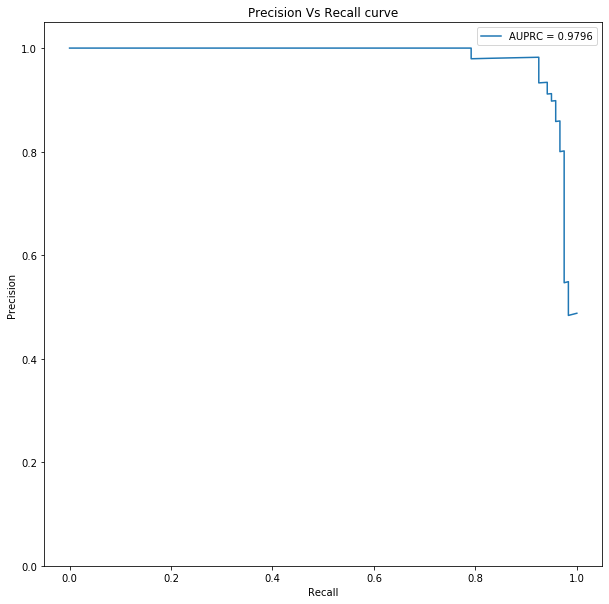

In [15]:
plot_precision_recall_curve(y_test_us,y_score_us)
plot_summary_results(y_test_us,y_pred_us)
#plot_summary(y_test_us,y_score_us)

 Here Recall ~0.93 & F1 Score of undersampling class 1(Fraud) is ~0.98 


# Random Over Sampling

replicate minority samples(Class 1) to reach Class 0 number of samples

Train - Class0 & Class1 Frequency & Ratio : 


class 0 - Normal : Count fom total Train :284315 , Ratio of samples from total train size  : 0.5 %
class 1 - Fraud  : Count fom total Train :284315 , Ratio of samples from total train size  : 0.5 %


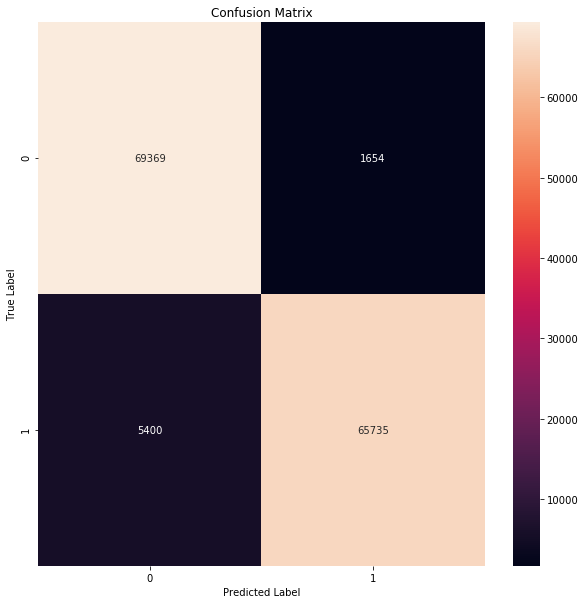

In [16]:
oversampling = RandomOverSampler() #random_state = 42
X_OS, Y_OS = oversampling.fit_sample(X_all,Y_all)
 

x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(X_OS, Y_OS, test_size = 0.25, random_state = 42)

oversampling_model = LogisticRegression()
oversampling_model.fit(x_train_os, y_train_os)

y_pred_os = oversampling_model.predict(x_test_os)
y_score_os = undersampling_model.decision_function(x_test_os)

get_class0_class1_ratio(Y_OS)
plot_confusion_matrix(y_test_os, y_pred_os)

Classification report : 


              precision    recall  f1-score   support

           0       0.93      0.98      0.95     71023
           1       0.98      0.92      0.95     71135

    accuracy                           0.95    142158
   macro avg       0.95      0.95      0.95    142158
weighted avg       0.95      0.95      0.95    142158



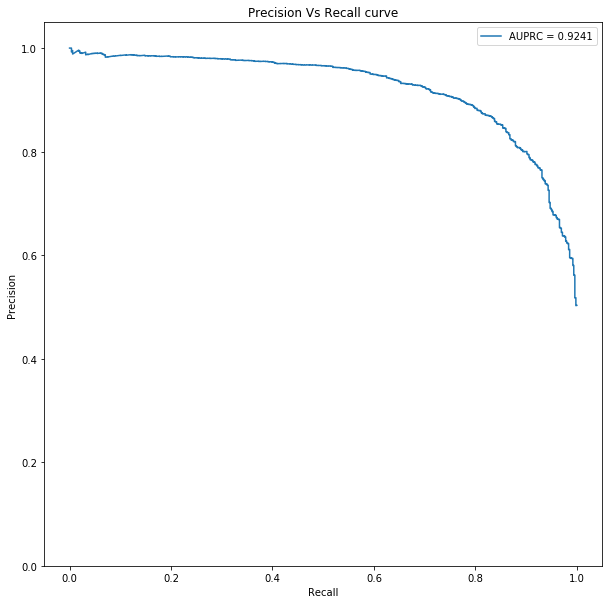

In [17]:
plot_precision_recall_curve(y_test_os,y_score_os)
plot_summary_results(y_test_os,y_pred_os)

#plot_summary(y_test_os,y_score_os)

Here Recall ~0.92 & F1 Score of oversampling class 1(Fraud) is ~0.98 


# Balanced Class Weight
This is technique gives more weightage to minority class. Due to this penalty model can able to predict well minority class on unseen data



Train - Class0 & Class1 Frequency & Ratio : 


class 0 - Normal : Count fom total Train :284315 , Ratio of samples from total train size  : 0.9983 %
class 1 - Fraud  : Count fom total Train :492 , Ratio of samples from total train size  : 0.0017 %


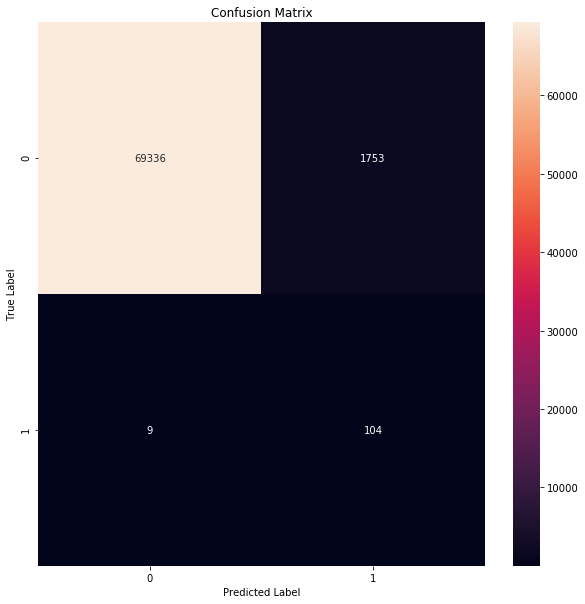

In [18]:
x_train_bcw, x_test_bcw, y_train_bcw, y_test_bcw = train_test_split(X_all, Y_all, test_size = 0.25, random_state = 42)

bcw_model = LogisticRegression(class_weight='balanced')
bcw_model.fit(x_train_bcw, y_train_bcw)

y_pred_bcw = bcw_model.predict(x_test_bcw)
y_score_bcw = bcw_model.decision_function(x_test_bcw)

get_class0_class1_ratio(Y_all)
plot_confusion_matrix(y_test_bcw, y_pred_bcw)

Classification report : 


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71089
           1       0.06      0.92      0.11       113

    accuracy                           0.98     71202
   macro avg       0.53      0.95      0.55     71202
weighted avg       1.00      0.98      0.99     71202



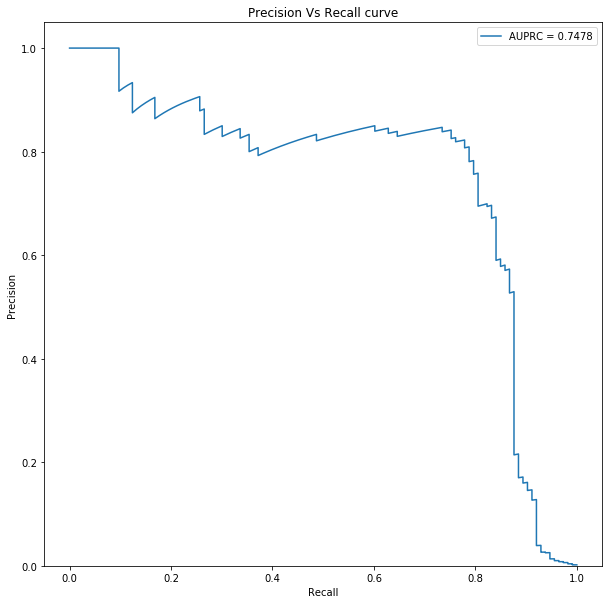

In [19]:
plot_precision_recall_curve(y_test_bcw,y_score_bcw)
plot_summary_results(y_test_bcw,y_pred_bcw)

#plot_summary(y_test_bcw,y_score_bcw)

weight balanced model predicts ~0.92 recall with low <0.1 F1 score


# XGBoost

XGBoost stands for Extreme Gradient Boosting; it is a specific implementation of the Gradient Boosting method which uses more accurate approximations to find the best tree model. It employs a number of nifty tricks that make it exceptionally successful, particularly with structured data.

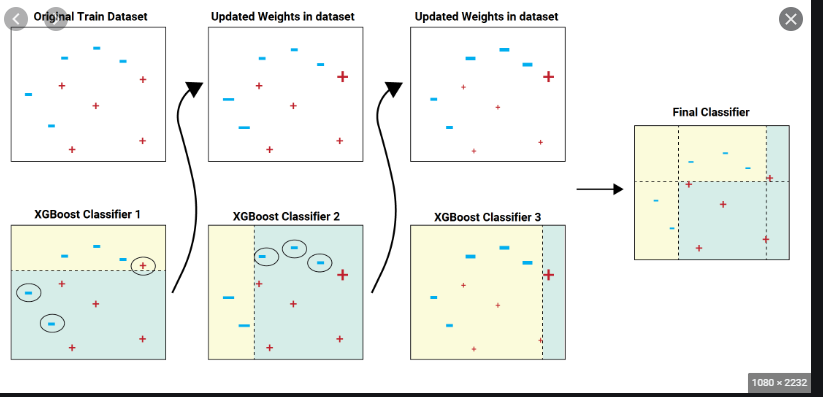

Train - Class0 & Class1 Frequency & Ratio : 


class 0 - Normal : Count fom total Train :284315 , Ratio of samples from total train size  : 0.9983 %
class 1 - Fraud  : Count fom total Train :492 , Ratio of samples from total train size  : 0.0017 %


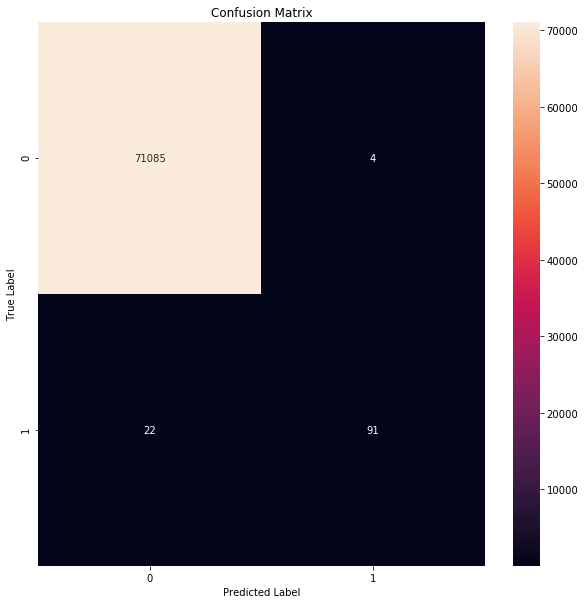

In [20]:

x_train_xgb, x_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_all, Y_all, test_size = 0.25, random_state = 42)

xgb_model = XGBClassifier(class_weight='balanced')
xgb_model.fit(x_train_bcw, y_train_xgb)

y_pred_xgb = xgb_model.predict(x_test_xgb)
#y_score_xgb = xgb_model.decision_function(x_test_xgb)

get_class0_class1_ratio(Y_all)
plot_confusion_matrix(y_test_xgb, y_pred_xgb)

In [21]:
#plot_precision_recall_curve(y_test_xgb,y_score_xgb)
plot_summary_results(y_test_xgb,y_pred_xgb)


#plot_summary(y_test_bcw,y_score_xgb)

Classification report : 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.96      0.81      0.88       113

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202



Recall ~0.81 , F1 score ~0.97


# We trained 5 different model - let's compare classification parameters for the complete dataset


In [22]:
models = []
models.append(('Base Model', base_model))
models.append(('Under Sampling Model', undersampling_model))
models.append(('Over Sampling Model', oversampling_model))
models.append(('Balanced Model', bcw_model))
models.append(('XGB Model', xgb_model))

In [23]:
def model_evaluation(y_train, y_pred):
        
    precision,recall,f1score,support=precision_recall_fscore_support(y_train, y_pred, average='macro')
    acc=accuracy_score(y_train, y_pred)


    return(recall,f1score,precision,acc)

In [24]:
#col = ['Model','TP','TN','FP','FN','TPR','TNR','Precision','F1 Score','Accuracy']
col = ['Model','Recall','F1 Score','Precision','Accuracy']
model_idx = 0
model_eval = pd.DataFrame(columns = col)

for model_type, model in models:
   
    Y_pred = model.predict(X_all)
    recall,f1score,precision,acc = model_evaluation(Y_all, Y_pred)
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    #model_eval.loc[model_idx] = [model_type,tp,tn,fp,fn,tpr,tnr,precision,fscore,acc]
    model_eval.loc[model_idx] = [model_type,recall,f1score,precision,acc]

    model_idx+=1
    
model_eval

,Model,Recall,F1 Score,Precision,Accuracy
0,Base Model,0.814,0.866,0.940,0.999
1,Under Sampling Model,0.804,0.407,0.502,0.672
2,Over Sampling Model,0.950,0.555,0.532,0.977
3,Balanced Model,0.947,0.551,0.530,0.975
4,XGB Model,0.978,0.987,0.996,1.000



# Conclusions 

1.	Base Model : overall good performance but most important parameter (recall ) is low 
2.	Under Sampling Model : Preformed good in training , but when tested on new data set provided low results 
3.	Over Sampling Model : We get very good recall but other parameters (accuracy ,F1 ,etc..) are low 
4.	Balanced Model : We get very good recall but other parameters (accuracy ,F1 ,etc..) are low 
5.	XGB model : manage to get both high recall & high accuracy & F1 score – this is the best model. 

We can also tune XGBoost hyper parameters to improve recall but I believe results are sufficient . 


big thanks to 

https://www.kaggle.com/balams/imbalanced-dataset-logisticregression